# Data

**Fundamental Energy Data (Provided)**

*Recent and Historic Energy Statistics*

* crude_oil_production_deseasonalized.csv
    
    * Residual from detrended and de-seasonalized oil production data 
    

* petroleum_consumption_deseasonalized.csv
    
    * Residual from detrended and de-seasonalized oil consumption data


<br>

**Market Data**

*Futures Curves (From Refinitiv)*

* wti_futures_curves_diffs.csv
    * Contains spot prices, % difference of each consecutive futures contract from spot, and 1-month Implied Volatility (%) on the front-month futures contract (from volatility smile in wti_continuous_options_moneyness.csv)


*Energy Sector Stocks and Commodities (HLOC) (Provided)*

* wti_price.csv
    * Price series of WTI Crude Oil

* log_geom_diff_wti_price.csv 
    * Difference in logs of WTI price 
    
* SPY.csv
    * Price series of S&P 500 index

* SPY_log_geom_diff.csv
    * Difference in logs of SPY price

* IYE.csv
    * Price series of IYE (U.S. Energy Companies) Index
* IYE_log_geom_diff.csv
    * Difference in logs of IYE price


In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm

#

## Import Data

In [171]:
# Import Data

# Consumption
petroleum_consumption_deseasonalized = pd.read_csv(r"data\\cleaned_data\\consumption_production\\petroleum_consumption_deseasonalized.csv")
#Production
crude_oil_production_deseasonalized = pd.read_csv(r"data\\cleaned_data\\consumption_production\\crude_oil_production_deseasonalized.csv")

# Futures
wti_futures_curves_diffs = pd.read_csv(r"data\cleaned_data\futures\wti_futures_diffs.csv")
wti_futures_curves_diffs.set_index("Unnamed: 0", inplace=True)
wti_futures_curves_diffs.index.name = "Date"
wti_futures_curves_diffs.index = pd.to_datetime(wti_futures_curves_diffs.index)




# Stocks and Commodity Prices
wti_price = pd.read_csv(r"data\\cleaned_data\\prices\\wti_price.csv")
log_geom_diff_wti_price = pd.read_csv(r"data\\cleaned_data\\prices\\log_geom_diff_wti_price.csv")

log_geom_diff_spy = pd.read_csv(r"data\\cleaned_data\\prices\\SPY_log_geom_diff.csv")
log_geom_diff_spy.set_index('Date-Time', inplace=True)
log_geom_diff_spy.index = pd.to_datetime(log_geom_diff_spy.index)

log_geom_diff_iye = pd.read_csv(r"data\\cleaned_data\\prices\\IYE_log_geom_diff.csv")
log_geom_diff_iye.set_index('Date', inplace=True)
log_geom_diff_iye.index = pd.to_datetime(log_geom_diff_iye.index, utc=True)



# Model

$$
\sigma_m = \alpha + \beta' X_m + \epsilon_m
$$

where $m$ represents the current month and $\beta, X$ are length 9 with:

1. **$X_1$: One Month Lagged Volatility in WTI Price** - This variable captures the volatility of oil prices from the previous month, based on the assumption that past volatility can influence future volatility through mechanisms like volatility clustering.

2. **$X_2$: One Month Lagged Change in Spot Price** - The month-over-month percentage log-geometric change in the spot price of WTI Crude oil. This variable helps to understand how recent price movements might influence the market's volatility expectations.

3. **$X_3$: Moving Average of Production** - Calculated as the moving average (MA) of oil production over a specified number of periods (p). This indicator can reflect supply-side trends influencing market volatility.

4. **$X_4$: Moving Average of Consumption** - Similar to $X_3$, but for oil consumption, indicating demand-side influences on market volatility. The moving average is calculated over the same number of periods (p) for consistency.

5. **$X_5$: % Difference Between Spot and Front Month Contract** - This variable measures the short-term market sentiment and immediate supply and demand dynamics by comparing the spot price to the price of the nearest futures contract.

6. **$X_6$: Average % Difference Between Spot and the Next 11 Contracts** - Reflects medium-term market expectations beyond the immediate future by averaging the price differences between the spot and the next 11 futures contracts.

7. **$X_7$: Average % Difference Between Spot and Contracts [13: ]** - Averages the percentage difference between the spot price and long-term futures contracts (from the 13th contract onwards), indicating long-term market expectations.

8. **$X_8$: 1 Month Lagged Volatility in S&P 500** - Standard deviation in the prior month's observed SPY log-geometric differences.

9. **$X_9$: 1 Month Lagged Volatility in IYE (iShares U.S. Energy ETF)** - Standard deviation in the prior month's observed IYE log-geometric differences.

10. **$X_{10}$: 1 Month Average Implied Volatility (IV) on Front Month WTI Futures** - Average over Implied Volatility calculated for 1 month-to-expiry options on the front month WTI Crude future with moneyness from 80% - 120% in increments of 5%.


In [172]:
# Get monthly volatility in WTI Oil Price

log_geom_diff_wti_price.set_index('Date_Time', inplace=True)
log_geom_diff_wti_price.index = pd.to_datetime(log_geom_diff_wti_price.index)



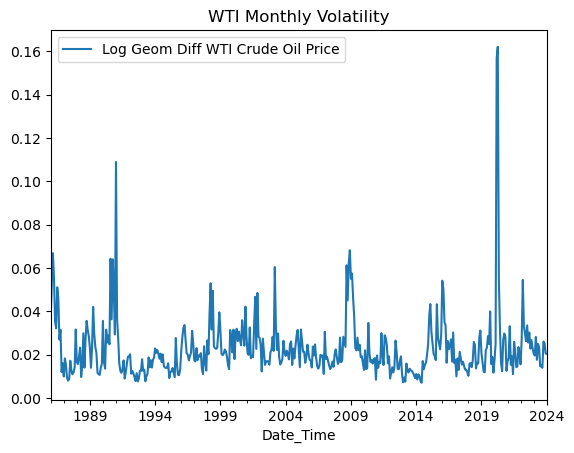

In [173]:
WTI_monthly_vol = log_geom_diff_wti_price.groupby(pd.Grouper(freq='M')).std()
WTI_monthly_vol.rename(columns={'WTI_Price': 'WTI_Monthly_Vol'}, inplace=True)

WTI_monthly_vol.plot()
plt.title('WTI Monthly Volatility')
plt.show()


In [174]:
# # Define vars

# # Model

# $$
# \sigma_m = \alpha + \beta' X_m + \epsilon_m
# $$

# where $m$ represents the current month and $\beta, X$ are length 9 with:

# 1. **$X_1$: One Month Lagged Volatility in WTI Price** - This variable captures the volatility of oil prices from the previous month, based on the assumption that past volatility can influence future volatility through mechanisms like volatility clustering.

# 2. **$X_2$: One Month Lagged Change in Spot Price** - The month-over-month percentage log-geometric change in the spot price of WTI Crude oil. This variable helps to understand how recent price movements might influence the market's volatility expectations.

# 3. **$X_3$: Moving Average of Production** - Calculated as the moving average (MA) of oil production over a specified number of periods (p). This indicator can reflect supply-side trends influencing market volatility.

# 4. **$X_4$: Moving Average of Consumption** - Similar to $X_3, but for oil consumption, indicating demand-side influences on market volatility. The moving average is calculated over the same number of periods (p) for consistency.

# 5. **$X_5$: % Difference Between Spot and Front Month Contract** - This variable measures the short-term market sentiment and immediate supply and demand dynamics by comparing the spot price to the price of the nearest futures contract.

# 6. **$X_6$: Average % Difference Between Spot and the Next 11 Contracts** - Reflects medium-term market expectations beyond the immediate future by averaging the price differences between the spot and the next 11 futures contracts.

# 7. **$X_7$: Average % Difference Between Spot and Contracts [13: ]** - Averages the percentage difference between the spot price and long-term futures contracts (from the 13th contract onwards), indicating long-term market expectations.

# 8. **$X_8$: 1 Month Lagged Volatility in S&P 500** - Incorporates broader market volatility into the model, as financial markets can be interconnected, and overall market volatility can influence commodity prices, including oil.

# 9. **$X_9$: 1 Month Lagged Volatility in IYE (iShares U.S. Energy ETF)** - This variable specifically captures the volatility in the energy sector, potentially offering insights into sector-specific factors affecting oil price volatility.

# 10. **$X_{10}$: 1 Month Average Implied Volatility (IV) from Options on Front Month WTI Futures** - This is a direct measure of the market's expectation of future volatility, derived from the options market.


# Create X and Y dfs
Y = WTI_monthly_vol.copy()
X = pd.DataFrame()

# X1: One Month Lagged Volatility in WTI Price
X['WTI_Lagged_Vol'] = WTI_monthly_vol['Log Geom Diff WTI Crude Oil Price'].shift(1)

# X2: One Month Lagged Change in Spot Price
# Get log geom diff of spot price, sum changes per month to get monthly log geom diff in stock price
monthly_log_geom_diff_wti_spot = log_geom_diff_wti_price.groupby(pd.Grouper(freq='M')).sum()
monthly_log_geom_diff_wti_spot.rename(columns={'Log Geom Diff WTI Crude Oil Price': 'Monthly_Log_Geom_Diff_WTI_Spot'}, inplace=True)
# Get 1 month lag
X['WTI_Lagged_Spot_Change'] = monthly_log_geom_diff_wti_spot['Monthly_Log_Geom_Diff_WTI_Spot'].shift(1)

# X3: Moving Average of Production
p = 12
X['Crude_Oil_Production_MA'] = crude_oil_production_deseasonalized['Crude Oil Production'].rolling(window=p).mean()

# X4: Moving Average of Consumption
X['Petroleum_Consumption_MA'] = petroleum_consumption_deseasonalized['Petroleum Consumption'].rolling(window=p).mean()

# X5: % Difference Between Spot and Front Month Contract
X['Spot_Front_Month_Diff'] = wti_futures_curves_diffs['contract1 % diff from spot']

# X6: Average % Difference Between Spot and the Next 11 Contracts
# get the average of the next 11 contracts
avg_med = wti_futures_curves_diffs.iloc[:, 3:14].mean(axis=1)
X['Spot_Next_11_Contracts_Avg'] = avg_med

# X7: Average % Difference Between Spot and Contracts [13: ]
# get the average of the contracts from 13 onwards
avg_long = wti_futures_curves_diffs.iloc[:, 14:].mean(axis=1)
X['Spot_Long_Contracts_Avg'] = avg_long

# X8: 1 Month Lagged Volatility in S&P 500
# create get std of log geom changes per month in spy
monthly_vol_spy = log_geom_diff_spy.groupby(pd.Grouper(freq='M')).std()
# monthly_vol_spy.rename(columns={'Close': 'Monthly_Vol_S&P_500'}, inplace=True)
# X['SPY_Lagged_Vol'] = monthly_vol_spy['Monthly_Vol_S&P_500'].shift(1)


# X9: 1 Month Lagged Volatility in IYE
# create get std of log geom changes per month in iye
monthly_vol_iye = log_geom_diff_iye.groupby(pd.Grouper(freq='M')).std()
monthly_vol_iye.rename(columns={'Close': 'Monthly_Vol_IYE'}, inplace=True)
X['IYE_Lagged_Vol'] = monthly_vol_iye['Monthly_Vol_IYE'].shift(1)

# X10: 1 Month Average Implied Volatility (IV) from Options on Front Month WTI Futures
X['IV_Front_Month_WTI'] = wti_futures_curves_diffs.iloc[:, 0]

In [177]:
# Inspect X
X.describe()

,WTI_Lagged_Vol,WTI_Lagged_Spot_Change,Crude_Oil_Production_MA,Petroleum_Consumption_MA,Spot_Front_Month_Diff,Spot_Next_11_Contracts_Avg,Spot_Long_Contracts_Avg,IYE_Lagged_Vol,IV_Front_Month_WTI
Date_Time,,,,,,,,,
1986-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-02-28,0.037239,0.383410,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-31,0.053355,0.287766,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-04-30,0.066771,-0.028346,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-05-31,0.055265,-0.215024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-09-30,0.015046,-0.049744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-31,0.013849,-0.023584,NaN,NaN,0.007652,0.045259,0.177307,NaN,43.716667
2023-11-30,0.025981,0.127710,NaN,NaN,-0.003949,0.009330,0.134709,NaN,42.740000
